#UIDAI DEMOGRAPHIC LIFECYCLE ANALYSIS

###CELL 1: SETUP AND INSTALLATIONS

In [ ]:
import sys
!{sys.executable} -m pip install pandas numpy matplotlib seaborn scipy -q

print("✓ All packages installed successfully!\n")

✓ All packages installed successfully!



### CELL 2: IMPORT LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Configure display and plotting
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 120)
pd.set_option('display.max_rows', 100)

plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 11

print("="*80)
print("✓ Libraries imported successfully")
print("="*80)

✓ Libraries imported successfully


### CELL 3: UPLOAD DATA FILE, LOAD AND VALIDATE DATA

In [ ]:
from google.colab import files
import zipfile

print("\n" + "="*80)
print("STEP 1: UPLOAD YOUR DEMOGRAPHIC DATA FILE")
print("="*80)
print("\nPlease upload: data_final_cleaned_Demo.zip")
print("(Click 'Choose Files' button that appears below)\n")

# Upload ZIP
uploaded = files.upload()
zip_name = list(uploaded.keys())[0]
print(f"\n✓ File uploaded: {zip_name}")

print("\n" + "="*80)
print("STEP 2: LOADING AND VALIDATING DEMOGRAPHIC DATA")
print("="*80)

# Read CSV safely from ZIP (ignores __MACOSX junk)
with zipfile.ZipFile(zip_name, 'r') as z:
    print("Files inside ZIP:", z.namelist())
    with z.open('data_final_cleaned_Demo.csv') as f:
        df = pd.read_csv(f)

# Date handling
df['date'] = pd.to_datetime(df['date'])

# Add year_month if not present
if 'year_month' not in df.columns:
    df['year_month'] = df['date'].dt.to_period('M').astype(str)

# Validation summary
print(f"\n✓ Data loaded successfully!")
print(f"  - Total records: {len(df):,}")
print(f"  - Total columns: {len(df.columns)}")
print(f"  - Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"  - States: {df['state'].nunique()}")
print(f"  - Districts: {df['district'].nunique()}")
print(f"  - Pincodes: {df['pincode'].nunique()}")
print(f"  - Total demographic updates: {df['total_demographic'].sum():,}")

print("\nCRITICAL DISCOVERY:")
print("  • This is DEMOGRAPHIC UPDATE data (age bands: 5–17 and 17+)")
print("  • NOT initial enrolment data (no 0–5 cohort)")
print("  • Captures lifecycle corrections, not first registrations")

print("\nFirst few rows:")
display(df.head())


STEP 1: UPLOAD YOUR DEMOGRAPHIC DATA FILE

Please upload: data_final_cleaned_Demo.zip
(Click 'Choose Files' button that appears below)



Saving data_final_cleaned_Demo.csv.zip to data_final_cleaned_Demo.csv (2).zip

✓ File uploaded: data_final_cleaned_Demo.csv (2).zip

STEP 2: LOADING AND VALIDATING DEMOGRAPHIC DATA
Files inside ZIP: ['data_final_cleaned_Demo.csv', '__MACOSX/._data_final_cleaned_Demo.csv']

✓ Data loaded successfully!
  - Total records: 2,071,694
  - Total columns: 20
  - Date range: 2025-03-01 to 2025-12-29
  - States: 36
  - Districts: 952
  - Pincodes: 19741
  - Total demographic updates: 49,295,181

CRITICAL DISCOVERY:
  • This is DEMOGRAPHIC UPDATE data (age bands: 5–17 and 17+)
  • NOT initial enrolment data (no 0–5 cohort)
  • Captures lifecycle corrections, not first registrations

First few rows:


,date,state,district,pincode,demo_age_5_17,demo_age_17_above,state_original,district_original,pincode_original,pincode_valid,geo_flag,date_original,has_negative_age,total_demographic,has_extreme_value,pct_age_5_17,pct_age_17_above,age_flag,exclude_from_analysis,year_month
0,2025-03-01,Uttar Pradesh,Gorakhpur,273213,49,529,Uttar Pradesh,Gorakhpur,273213,True,False,2025-03-01,False,578,True,8.477509,91.522491,False,False,2025-03
1,2025-03-01,Andhra Pradesh,Chittoor,517132,22,375,Andhra Pradesh,Chittoor,517132,True,False,2025-03-01,False,397,True,5.541562,94.458438,False,False,2025-03
2,2025-03-01,Gujarat,Rajkot,360006,65,765,Gujarat,Rajkot,360006,True,False,2025-03-01,False,830,True,7.831325,92.168675,False,False,2025-03
3,2025-03-01,Andhra Pradesh,Srikakulam,532484,24,314,Andhra Pradesh,Srikakulam,532484,True,False,2025-03-01,False,338,True,7.100592,92.899408,False,False,2025-03
4,2025-03-01,Rajasthan,Udaipur,313801,45,785,Rajasthan,Udaipur,313801,True,False,2025-03-01,False,830,True,5.421687,94.578313,False,False,2025-03


### CELL 4: ADD DERIVED FEATURES

In [ ]:
print("\n" + "="*80)
print("STEP 3: CREATING DERIVED DEMOGRAPHIC FEATURES")
print("="*80)

# Temporal features
df['day_of_week'] = df['date'].dt.day_name()
df['is_weekend'] = df['day_of_week'].isin(['Saturday', 'Sunday'])

# Batch size categories
df['batch_size_category'] = pd.cut(
    df['total_demographic'],
    bins=[0, 5, 20, 100, np.inf],
    labels=['Small (1-5)', 'Medium (6-20)', 'Large (21-100)', 'Mega (100+)']
)

# Age dominance
df['dominant_age'] = 'Adult'
df.loc[df['demo_age_5_17'] > df['demo_age_17_above'], 'dominant_age'] = 'Youth'
df.loc[df['demo_age_5_17'] == df['demo_age_17_above'], 'dominant_age'] = 'Equal'

# Pure age batches
df['is_pure_adult'] = (df['demo_age_17_above'] > 0) & (df['demo_age_5_17'] == 0)
df['is_pure_youth'] = (df['demo_age_5_17'] > 0) & (df['demo_age_17_above'] == 0)
df['is_mixed_age'] = (df['demo_age_5_17'] > 0) & (df['demo_age_17_above'] > 0)

print("✓ Created derived features:")
print("  - day_of_week, is_weekend")
print("  - batch_size_category (4 levels)")
print("  - dominant_age (Youth/Adult/Equal)")
print("  - is_pure_adult, is_pure_youth, is_mixed_age")


STEP 3: CREATING DERIVED DEMOGRAPHIC FEATURES
✓ Created derived features:
  - day_of_week, is_weekend
  - batch_size_category (4 levels)
  - dominant_age (Youth/Adult/Equal)
  - is_pure_adult, is_pure_youth, is_mixed_age


### CELL 5: DEMOGRAPHIC GRAIN & BEHAVIORAL PROXY

In [ ]:
print("\n" + "="*80)
print(" PHASE 1: DEMOGRAPHIC GRAIN & BEHAVIORAL PROXY")
print("="*80)

print("\n BATCH SIZE CHARACTERISTICS:")
print(f"  Median batch: {df['total_demographic'].median():.0f}")
print(f"  Mean batch: {df['total_demographic'].mean():.1f}")
print(f"  Single-person updates: {(df['total_demographic']==1).sum():,} ({(df['total_demographic']==1).sum()/len(df)*100:.1f}%)")
print(f"  Small batches (1-5): {(df['total_demographic']<=5).sum():,} ({(df['total_demographic']<=5).sum()/len(df)*100:.1f}%)")

print("\n AGE DOMINANCE PATTERN:")
adult_dominant = (df['dominant_age'] == 'Adult').sum()
youth_dominant = (df['dominant_age'] == 'Youth').sum()
equal = (df['dominant_age'] == 'Equal').sum()

print(f"  Adult-dominant: {adult_dominant:,} ({adult_dominant/len(df)*100:.1f}%)")
print(f"  Youth-dominant: {youth_dominant:,} ({youth_dominant/len(df)*100:.1f}%)")
print(f"  Equal: {equal:,} ({equal/len(df)*100:.1f}%)")

print("\n AVERAGE AGE COMPOSITION:")
print(f"  % Youth (5-17): {df['pct_age_5_17'].mean():.1f}%")
print(f"  % Adult (17+): {df['pct_age_17_above'].mean():.1f}%")

print("\n BEHAVIORAL INTERPRETATION:")
print(f"  {adult_dominant/len(df)*100:.0f}% adult-dominant + {(df['total_demographic']<=5).sum()/len(df)*100:.0f}% small batches")
print(f"  = INDIVIDUAL LIFECYCLE EVENTS (address, marriage, employment)")
print(f"  NOT: Birth registration or school admission drives")


 PHASE 1: DEMOGRAPHIC GRAIN & BEHAVIORAL PROXY

 BATCH SIZE CHARACTERISTICS:
  Median batch: 7
  Mean batch: 23.8
  Single-person updates: 293,739 (14.2%)
  Small batches (1-5): 932,170 (45.0%)

 AGE DOMINANCE PATTERN:
  Adult-dominant: 1,953,050 (94.3%)
  Youth-dominant: 60,102 (2.9%)
  Equal: 58,542 (2.8%)

 AVERAGE AGE COMPOSITION:
  % Youth (5-17): 11.2%
  % Adult (17+): 88.8%

 BEHAVIORAL INTERPRETATION:
  94% adult-dominant + 45% small batches
  = INDIVIDUAL LIFECYCLE EVENTS (address, marriage, employment)
  NOT: Birth registration or school admission drives


### CELL 6: INSIGHT 1 - ADULT DOMINANCE PARADOX

In [ ]:
print("\n" + "="*80)
print(" INSIGHT 1: THE ADULT DOMINANCE PARADOX")
print("="*80)

# Overall adult dominance
overall_youth_pct = df['pct_age_5_17'].mean()
overall_adult_pct = df['pct_age_17_above'].mean()

print(f"\n DEMOGRAPHIC SIGNAL:")
print(f"  Youth (5-17): {overall_youth_pct:.1f}% of all updated individuals")
print(f"  Adult (17+): {overall_adult_pct:.1f}% of all updated individuals")

print(f"\n  Expected from demographics: ~26% youth (census)")
print(f"  Actual in updates: {overall_youth_pct:.1f}% youth")
print(f"  DISCREPANCY: Youth under-represented by {(26 - overall_youth_pct)/26*100:.0f}%")

# Pure adult batches
pure_adult_count = df['is_pure_adult'].sum()
pure_adult_pct = pure_adult_count / len(df) * 100

print(f"\n PURE ADULT BATCHES:")
print(f"  Count: {pure_adult_count:,}")
print(f"  Percentage: {pure_adult_pct:.1f}%")
print(f"  Large pure adult (>50): {df[df['is_pure_adult'] & (df['total_demographic']>50)].shape[0]:,}")

print(f"\n LIFECYCLE INTERPRETATION:")
print(f"  {pure_adult_pct:.0f}% of batches have ZERO youth")
print(f"  = Children excluded from parent updates")
print(f"  = Youth invisible until they become adults at 18")

print(f"\n UIDAI ACTION:")
print(f"  1. Mandate 'Update Dependents' prompt in adult transactions")
print(f"  2. Show last-update date for registered dependents")
print(f"  3. Fee waiver for family-complete updates")


 INSIGHT 1: THE ADULT DOMINANCE PARADOX

 DEMOGRAPHIC SIGNAL:
  Youth (5-17): 11.2% of all updated individuals
  Adult (17+): 88.8% of all updated individuals

  Expected from demographics: ~26% youth (census)
  Actual in updates: 11.2% youth
  DISCREPANCY: Youth under-represented by 57%

 PURE ADULT BATCHES:
  Count: 994,319
  Percentage: 48.0%
  Large pure adult (>50): 5,571

 LIFECYCLE INTERPRETATION:
  48% of batches have ZERO youth
  = Children excluded from parent updates
  = Youth invisible until they become adults at 18

 UIDAI ACTION:
  1. Mandate 'Update Dependents' prompt in adult transactions
  2. Show last-update date for registered dependents
  3. Fee waiver for family-complete updates


### CELL 7: INSIGHT 2 - WEEKEND FAMILY UPDATE PATTERN

In [ ]:
print("\n" + "="*80)
print(" INSIGHT 2: WEEKEND FAMILY UPDATE PATTERN")
print("="*80)

weekend_youth = df[df['is_weekend']]['pct_age_5_17'].mean()
weekday_youth = df[~df['is_weekend']]['pct_age_5_17'].mean()
weekend_surplus = weekend_youth - weekday_youth

weekend_batch = df[df['is_weekend']]['total_demographic'].mean()
weekday_batch = df[~df['is_weekend']]['total_demographic'].mean()
batch_increase = (weekend_batch - weekday_batch) / weekday_batch * 100

print(f"\n DEMOGRAPHIC SIGNAL:")
print(f"  Weekend youth %: {weekend_youth:.1f}%")
print(f"  Weekday youth %: {weekday_youth:.1f}%")
print(f"  Weekend surplus: +{weekend_surplus:.1f} percentage points")

print(f"\n BATCH SIZE SIGNAL:")
print(f"  Weekend avg batch: {weekend_batch:.1f}")
print(f"  Weekday avg batch: {weekday_batch:.1f}")
print(f"  Weekend increase: +{batch_increase:.0f}%")

print(f"\n LIFECYCLE INTERPRETATION:")
print(f"  Working parents bring entire families on weekends")
print(f"  Weekdays = individual adult walk-ins")
print(f"  Weekend is the ONLY inclusive window for employed families")

print(f"\n UIDAI ACTION:")
print(f"  1. Mandate weekend operations in all urban centers")
print(f"  2. Extend hours (Friday evening + Sunday afternoon)")
print(f"  3. Track state-level Weekend Family Update Index (WFUI)")


 INSIGHT 2: WEEKEND FAMILY UPDATE PATTERN

 DEMOGRAPHIC SIGNAL:
  Weekend youth %: 12.8%
  Weekday youth %: 10.7%
  Weekend surplus: +2.1 percentage points

 BATCH SIZE SIGNAL:
  Weekend avg batch: 36.8
  Weekday avg batch: 19.4
  Weekend increase: +90%

 LIFECYCLE INTERPRETATION:
  Working parents bring entire families on weekends
  Weekdays = individual adult walk-ins
  Weekend is the ONLY inclusive window for employed families

 UIDAI ACTION:
  1. Mandate weekend operations in all urban centers
  2. Extend hours (Friday evening + Sunday afternoon)
  3. Track state-level Weekend Family Update Index (WFUI)


### CELL 8: INSIGHT 3 - GEOGRAPHIC YOUTH EXCLUSION

In [ ]:
print("\n" + "="*80)
print(" INSIGHT 3: GEOGRAPHIC YOUTH EXCLUSION GRADIENT")
print("="*80)

# State-level youth representation
state_youth = df.groupby('state')['pct_age_5_17'].mean().sort_values(ascending=False)

print(f"\n TOP 5 STATES BY YOUTH REPRESENTATION:")
for i, (state, pct) in enumerate(state_youth.head(5).items(), 1):
    print(f"  {i}. {state}: {pct:.1f}%")

print(f"\n BOTTOM 5 STATES (MOST ADULT-DOMINATED):")
for i, (state, pct) in enumerate(state_youth.tail(5).items(), 1):
    print(f"  {i}. {state}: {pct:.1f}%")

top_youth = state_youth.iloc[0]
bottom_youth = state_youth.iloc[-1]
disparity = top_youth / bottom_youth

print(f"\n GEOGRAPHIC DISPARITY:")
print(f"  Highest: {state_youth.index[0]} at {top_youth:.1f}%")
print(f"  Lowest: {state_youth.index[-1]} at {bottom_youth:.1f}%")
print(f"  Ratio: {disparity:.1f}x difference")

print(f"\n LIFECYCLE INTERPRETATION:")
print(f"  Low-youth states = employment-migration hubs")
print(f"  Solo workers update addresses, families left behind")
print(f"  Children face accumulated errors at age 18")

print(f"\n UIDAI ACTION:")
print(f"  1. Deploy mobile family-update vans in bottom-10 states")
print(f"  2. Partner with schools for correction camps")
print(f"  3. Create origin-destination paired update facilities")



 INSIGHT 3: GEOGRAPHIC YOUTH EXCLUSION GRADIENT

 TOP 5 STATES BY YOUTH REPRESENTATION:
  1. Ladakh: 19.9%
  2. Manipur: 18.6%
  3. Arunachal Pradesh: 18.1%
  4. Tamil Nadu: 16.5%
  5. Telangana: 15.8%

 BOTTOM 5 STATES (MOST ADULT-DOMINATED):
  1. Andaman and Nicobar Islands: 7.2%
  2. Goa: 7.0%
  3. Maharashtra: 6.6%
  4. West Bengal: 6.0%
  5. Punjab: 5.4%

 GEOGRAPHIC DISPARITY:
  Highest: Ladakh at 19.9%
  Lowest: Punjab at 5.4%
  Ratio: 3.7x difference

 LIFECYCLE INTERPRETATION:
  Low-youth states = employment-migration hubs
  Solo workers update addresses, families left behind
  Children face accumulated errors at age 18

 UIDAI ACTION:
  1. Deploy mobile family-update vans in bottom-10 states
  2. Partner with schools for correction camps
  3. Create origin-destination paired update facilities


### CELL 9: INSIGHT 4 - BATCH SIZE VS AGE COMPOSITION

In [ ]:
print("\n" + "="*80)
print(" INSIGHT 4: INSTITUTIONAL MEGA-BATCH YOUTH DEFICIT")
print("="*80)

age_by_batch = df.groupby('batch_size_category').agg({
    'pct_age_5_17': 'mean',
    'pct_age_17_above': 'mean',
    'total_demographic': ['count', 'sum']
}).round(1)

age_by_batch.columns = ['Avg_%_Youth', 'Avg_%_Adult', 'Num_Batches', 'Total_People']
print("\n AGE COMPOSITION BY BATCH SIZE:")
print(age_by_batch)

mega_youth = age_by_batch.loc['Mega (100+)', 'Avg_%_Youth']
overall_youth = df['pct_age_5_17'].mean()
youth_deficit = overall_youth - mega_youth

print(f"\n YOUTH DEFICIT IN MEGA BATCHES:")
print(f"  Overall youth %: {overall_youth:.1f}%")
print(f"  Mega-batch youth %: {mega_youth:.1f}%")
print(f"  Deficit: {youth_deficit:.1f} percentage points")

mega_volume = age_by_batch.loc['Mega (100+)', 'Total_People']
total_volume = age_by_batch['Total_People'].sum()
mega_pct = mega_volume / total_volume * 100

print(f"\n  Mega batches represent {mega_pct:.0f}% of total volume")
print(f"  Yet have {youth_deficit:.1f}% lower youth representation")

print(f"\n LIFECYCLE INTERPRETATION:")
print(f"  Large institutions exclude employee dependents")
print(f"  Bulk processing optimized for speed, not family inclusion")
print(f"  Structural exclusion in institutional workflows")

print(f"\n UIDAI ACTION:")
print(f"  1. Audit top 100 institutional updaters")
print(f"  2. Mandate dependent verification for batches >200")
print(f"  3. Require family update windows during corporate updates")


 INSIGHT 4: INSTITUTIONAL MEGA-BATCH YOUTH DEFICIT

 AGE COMPOSITION BY BATCH SIZE:
                     Avg_%_Youth  Avg_%_Adult  Num_Batches  Total_People
batch_size_category                                                     
Small (1-5)                 11.7         88.3       930031       2363915
Medium (6-20)               11.5         88.5       707167       7751564
Large (21-100)               9.9         90.1       375671      15378990
Mega (100+)                  8.6         91.4        56686      23800712

 YOUTH DEFICIT IN MEGA BATCHES:
  Overall youth %: 11.2%
  Mega-batch youth %: 8.6%
  Deficit: 2.6 percentage points

  Mega batches represent 48% of total volume
  Yet have 2.6% lower youth representation

 LIFECYCLE INTERPRETATION:
  Large institutions exclude employee dependents
  Bulk processing optimized for speed, not family inclusion
  Structural exclusion in institutional workflows

 UIDAI ACTION:
  1. Audit top 100 institutional updaters
  2. Mandate dependent ve

### CELL 10: INSIGHT 5 - SEPTEMBER DEMOGRAPHIC STABILITY

In [ ]:
print("\n" + "="*80)
print(" INSIGHT 5: SEPTEMBER SHIFT (DEMOGRAPHIC NEUTRALITY)")
print("="*80)

pre_sep = df[df['year_month'].isin(['2025-03', '2025-04', '2025-05', '2025-06', '2025-07'])]
post_sep = df[df['year_month'].isin(['2025-09', '2025-10', '2025-11', '2025-12'])]

print(f"\n PRE-SEPTEMBER (Mar-Jul):")
print(f"  Records: {len(pre_sep):,}")
print(f"  Avg batch: {pre_sep['total_demographic'].mean():.1f}")
print(f"  Youth %: {pre_sep['pct_age_5_17'].mean():.1f}%")
print(f"  Adult %: {pre_sep['pct_age_17_above'].mean():.1f}%")

print(f"\n POST-SEPTEMBER (Sep-Dec):")
print(f"  Records: {len(post_sep):,}")
print(f"  Avg batch: {post_sep['total_demographic'].mean():.1f}")
print(f"  Youth %: {post_sep['pct_age_5_17'].mean():.1f}%")
print(f"  Adult %: {post_sep['pct_age_17_above'].mean():.1f}%")

volume_shift = len(post_sep) / len(pre_sep)
batch_shift = pre_sep['total_demographic'].mean() / post_sep['total_demographic'].mean()
age_stability = abs(post_sep['pct_age_5_17'].mean() - pre_sep['pct_age_5_17'].mean())

print(f"\n SHIFT MAGNITUDE:")
print(f"  Transaction volume: {volume_shift:.0f}x increase")
print(f"  Batch size: {batch_shift:.1f}x decrease")
print(f"  Age composition change: {age_stability:.1f} percentage points")

print(f"\n LIFECYCLE INTERPRETATION:")
print(f"  September shift is OPERATIONAL (granularity)")
print(f"  NOT DEMOGRAPHIC (age mix unchanged)")
print(f"  Confirms infrastructure is age-neutral (good design)")

print(f"\n UIDAI ACTION:")
print(f"  1. Replicate distributed model in rural areas")
print(f"  2. Maintain age-monitoring dashboards")
print(f"  3. Proves scalability without demographic distortion")


 INSIGHT 5: SEPTEMBER SHIFT (DEMOGRAPHIC NEUTRALITY)

 PRE-SEPTEMBER (Mar-Jul):
  Records: 23,388
  Avg batch: 775.4
  Youth %: 11.8%
  Adult %: 88.2%

 POST-SEPTEMBER (Sep-Dec):
  Records: 2,048,306
  Avg batch: 15.2
  Youth %: 11.2%
  Adult %: 88.8%

 SHIFT MAGNITUDE:
  Transaction volume: 88x increase
  Batch size: 51.0x decrease
  Age composition change: 0.6 percentage points

 LIFECYCLE INTERPRETATION:
  September shift is OPERATIONAL (granularity)
  NOT DEMOGRAPHIC (age mix unchanged)
  Confirms infrastructure is age-neutral (good design)

 UIDAI ACTION:
  1. Replicate distributed model in rural areas
  2. Maintain age-monitoring dashboards
  3. Proves scalability without demographic distortion


### CELL 11: DERIVED METRIC 1 - ADULT LIFECYCLE DOMINANCE INDEX

In [ ]:
print("\n" + "="*80)
print(" DERIVED METRIC 1: ADULT LIFECYCLE DOMINANCE INDEX (ALDI)")
print("="*80)

# State-level ALDI
state_aldi = df.groupby('state').apply(
    lambda x: (x['demo_age_17_above'].sum() / x['total_demographic'].sum() * 100),
    include_groups=False
).sort_values(ascending=False)

print(f"\n TOP 10 STATES BY ALDI (Most Adult-Dominated):")
for i, (state, aldi) in enumerate(state_aldi.head(10).items(), 1):
    print(f"  {i}. {state}: {aldi:.1f}%")

print(f"\n COMPUTATION:")
print(f"  ALDI = (Total adults in updates / Total people in updates) × 100")

high_aldi = (state_aldi > 92).sum()
print(f"\n CRISIS STATES:")
print(f"  {high_aldi} states have ALDI >92% (severe youth exclusion)")

print(f"\n WHAT IT SURFACES:")
print(f"  States >92% = 2x worse than demographic expectation")
print(f"  Indicates employment-migration without family inclusion")
print(f"  Youth inherit 'demographic debt' at adulthood")

print(f"\n UIDAI DECISION:")
print(f"  1. High-ALDI states need youth inclusion campaigns")
print(f"  2. Partner with schools for correction drives")
print(f"  3. Target: Reduce all states to <88% ALDI")



 DERIVED METRIC 1: ADULT LIFECYCLE DOMINANCE INDEX (ALDI)

 TOP 10 STATES BY ALDI (Most Adult-Dominated):
  1. Maharashtra: 94.6%
  2. West Bengal: 93.7%
  3. Punjab: 93.6%
  4. Jharkhand: 92.9%
  5. Sikkim: 92.4%
  6. Bihar: 92.1%
  7. Kerala: 91.8%
  8. Chhattisgarh: 91.8%
  9. Assam: 91.7%
  10. Andaman and Nicobar Islands: 91.5%

 COMPUTATION:
  ALDI = (Total adults in updates / Total people in updates) × 100

 CRISIS STATES:
  6 states have ALDI >92% (severe youth exclusion)

 WHAT IT SURFACES:
  States >92% = 2x worse than demographic expectation
  Indicates employment-migration without family inclusion
  Youth inherit 'demographic debt' at adulthood

 UIDAI DECISION:
  1. High-ALDI states need youth inclusion campaigns
  2. Partner with schools for correction drives
  3. Target: Reduce all states to <88% ALDI


### CELL 12: DERIVED METRIC 2 - WEEKEND FAMILY UPDATE INDEX

In [ ]:
print("\n" + "="*80)
print(" DERIVED METRIC 2: WEEKEND FAMILY UPDATE INDEX (WFUI)")
print("="*80)

# State-level WFUI
state_wfui = df.groupby('state').apply(
    lambda x: (x['is_weekend'].sum() / len(x) * 100),
    include_groups=False
).sort_values(ascending=False)

print(f"\n TOP 10 STATES BY WFUI (Best Weekend Access):")
for i, (state, wfui) in enumerate(state_wfui.head(10).items(), 1):
    print(f"  {i}. {state}: {wfui:.1f}%")

print(f"\n COMPUTATION:")
print(f"  WFUI = (Weekend updates / Total updates) × 100")

good_wfui = (state_wfui > 25).sum()
poor_wfui = (state_wfui < 20).sum()

print(f"\n ACCESS QUALITY:")
print(f"  {good_wfui} states have WFUI >25% (good access)")
print(f"  {poor_wfui} states have WFUI <20% (poor access)")

print(f"\n WHAT IT SURFACES:")
print(f"  Low WFUI = working families excluded")
print(f"  Must take weekday leave (income loss)")
print(f"  Direct equity indicator")

print(f"\n UIDAI DECISION:")
print(f"  1. Mandate minimum 20% WFUI in all states")
print(f"  2. Weekend operations in urban centers (>100K)")
print(f"  3. Extended hours (Friday eve + Sunday afternoon)")


 DERIVED METRIC 2: WEEKEND FAMILY UPDATE INDEX (WFUI)

 TOP 10 STATES BY WFUI (Best Weekend Access):
  1. Uttar Pradesh: 27.5%
  2. Telangana: 27.0%
  3. Chandigarh: 26.9%
  4. Delhi: 26.8%
  5. Ladakh: 26.2%
  6. Andhra Pradesh: 26.2%
  7. Uttarakhand: 26.1%
  8. Bihar: 26.1%
  9. Assam: 26.1%
  10. Madhya Pradesh: 26.1%

 COMPUTATION:
  WFUI = (Weekend updates / Total updates) × 100

 ACCESS QUALITY:
  17 states have WFUI >25% (good access)
  1 states have WFUI <20% (poor access)

 WHAT IT SURFACES:
  Low WFUI = working families excluded
  Must take weekday leave (income loss)
  Direct equity indicator

 UIDAI DECISION:
  1. Mandate minimum 20% WFUI in all states
  2. Weekend operations in urban centers (>100K)
  3. Extended hours (Friday eve + Sunday afternoon)


### CELL 13: DERIVED METRIC 3 - INSTITUTIONAL BATCH CONCENTRATION

In [ ]:
print("\n" + "="*80)
print(" DERIVED METRIC 3: INSTITUTIONAL BATCH CONCENTRATION (IBC)")
print("="*80)

# State-level IBC
state_ibc = df.groupby('state').apply(
    lambda x: ((x['total_demographic'] > 100).sum() / len(x) * 100),
    include_groups=False
).sort_values(ascending=False)

print(f"\n TOP 10 STATES BY IBC (Most Institutional):")
for i, (state, ibc) in enumerate(state_ibc.head(10).items(), 1):
    print(f"  {i}. {state}: {ibc:.2f}%")

print(f"\n COMPUTATION:")
print(f"  IBC = (Batches >100 / Total batches) × 100")

high_ibc = (state_ibc > 10).sum()
print(f"\n INSTITUTIONAL DOMINANCE:")
print(f"  {high_ibc} states have IBC >10%")

print(f"\n WHAT IT SURFACES:")
print(f"  High IBC = institutional update dominance")
print(f"  Risk: Dependents excluded from employer updates")
print(f"  Bulk processing efficiency vs family inclusion trade-off")

print(f"\n UIDAI DECISION:")
print(f"  1. Audit high-IBC states for dependent inclusion")
print(f"  2. Mandate family verification for institutional batches")
print(f"  3. Ensure individual access not crowded out")


 DERIVED METRIC 3: INSTITUTIONAL BATCH CONCENTRATION (IBC)

 TOP 10 STATES BY IBC (Most Institutional):
  1. Delhi: 12.57%
  2. Manipur: 9.88%
  3. Bihar: 8.28%
  4. Chhattisgarh: 7.17%
  5. Uttar Pradesh: 6.57%
  6. Haryana: 5.23%
  7. Maharashtra: 5.16%
  8. Jharkhand: 3.40%
  9. Chandigarh: 3.28%
  10. Madhya Pradesh: 3.14%

 COMPUTATION:
  IBC = (Batches >100 / Total batches) × 100

 INSTITUTIONAL DOMINANCE:
  1 states have IBC >10%

 WHAT IT SURFACES:
  High IBC = institutional update dominance
  Risk: Dependents excluded from employer updates
  Bulk processing efficiency vs family inclusion trade-off

 UIDAI DECISION:
  1. Audit high-IBC states for dependent inclusion
  2. Mandate family verification for institutional batches
  3. Ensure individual access not crowded out


### CELL 14: SUMMARY STATISTICS


In [ ]:
print("\n" + "="*80)
print(" SUMMARY: TOP NUMBERS FOR PRESENTATION")
print("="*80)

summary_stats = {
    'Dataset Overview': {
        'Total Records': f"{len(df):,}",
        'Total Updates': f"{df['total_demographic'].sum():,}",
        'States': df['state'].nunique(),
        'Date Range': f"{df['date'].min().date()} to {df['date'].max().date()}"
    },
    'Top 7 Demographic Insights': {
        '1. Adult Dominance': f"{overall_adult_pct:.1f}% (vs 75% expected)",
        '2. Pure Adult Batches': f"{pure_adult_pct:.1f}%",
        '3. Weekend Youth Surplus': f"+{weekend_surplus:.1f} percentage points",
        '4. Geographic Disparity': f"{disparity:.1f}x (top vs bottom state)",
        '5. Mega-Batch Deficit': f"{youth_deficit:.1f} percentage points",
        '6. September Stability': f"{age_stability:.1f}% age change",
        '7. High-ALDI States': f"{high_aldi} states >92%"
    }
}

for category, stats_dict in summary_stats.items():
    print(f"\n{category}:")
    for key, value in stats_dict.items():
        print(f"  {key}: {value}")

print("\n" + "="*80)
print(" CORE DEMOGRAPHIC ANALYSIS COMPLETE!")
print("="*80)


 SUMMARY: TOP NUMBERS FOR PRESENTATION

Dataset Overview:
  Total Records: 2,071,694
  Total Updates: 49,295,181
  States: 36
  Date Range: 2025-03-01 to 2025-12-29

Top 7 Demographic Insights:
  1. Adult Dominance: 88.8% (vs 75% expected)
  2. Pure Adult Batches: 48.0%
  3. Weekend Youth Surplus: +2.1 percentage points
  4. Geographic Disparity: 3.7x (top vs bottom state)
  5. Mega-Batch Deficit: 2.6 percentage points
  6. September Stability: 0.6% age change
  7. High-ALDI States: 6 states >92%

 CORE DEMOGRAPHIC ANALYSIS COMPLETE!


### CELL 15: CREATE VISUALIZATIONS


CREATING DEMOGRAPHIC VISUALIZATIONS

Creating Visualization 1: Adult Dominance Temporal Stability...
  ✓ Saved: demo_viz_1_adult_dominance.png


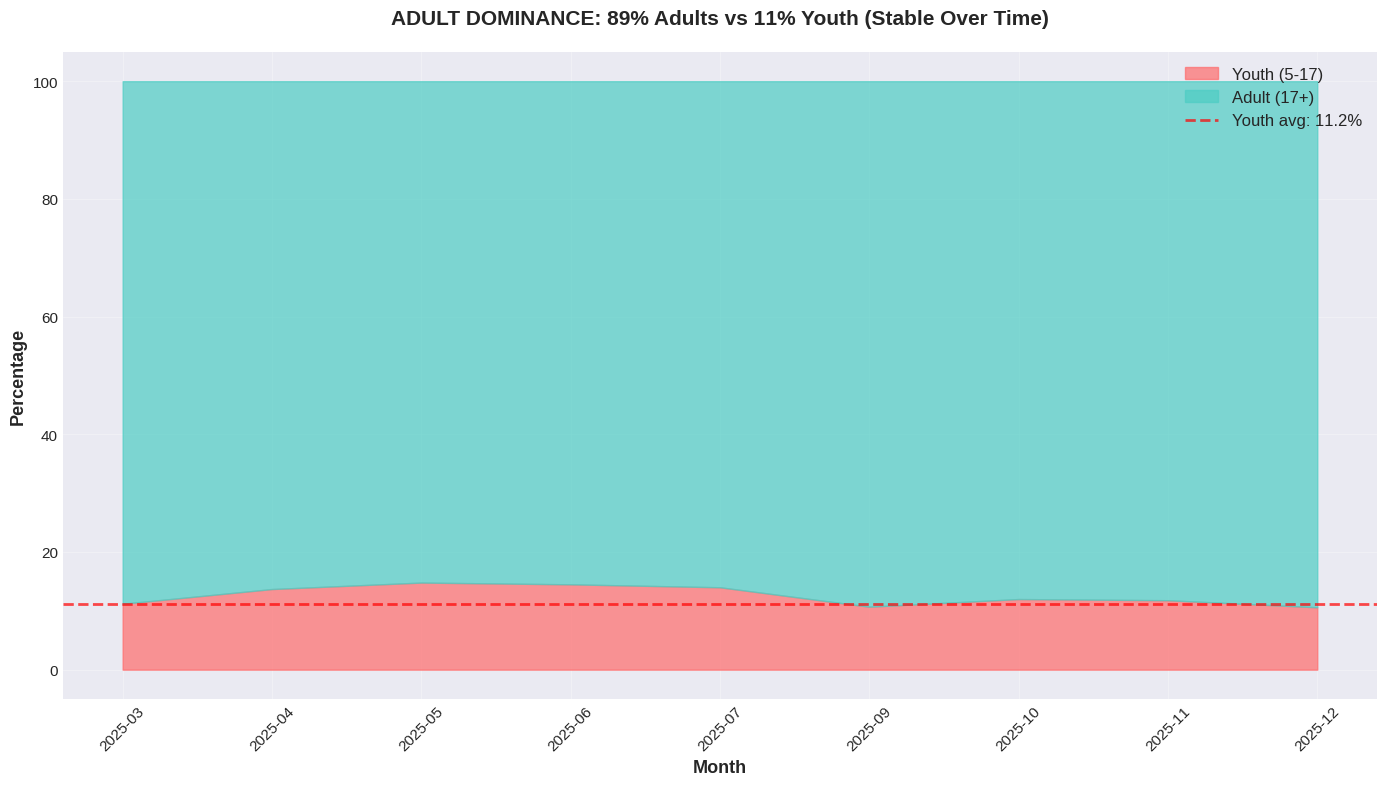


Creating Visualization 2: Weekend Family Update Pattern...
  ✓ Saved: demo_viz_2_weekend_pattern.png


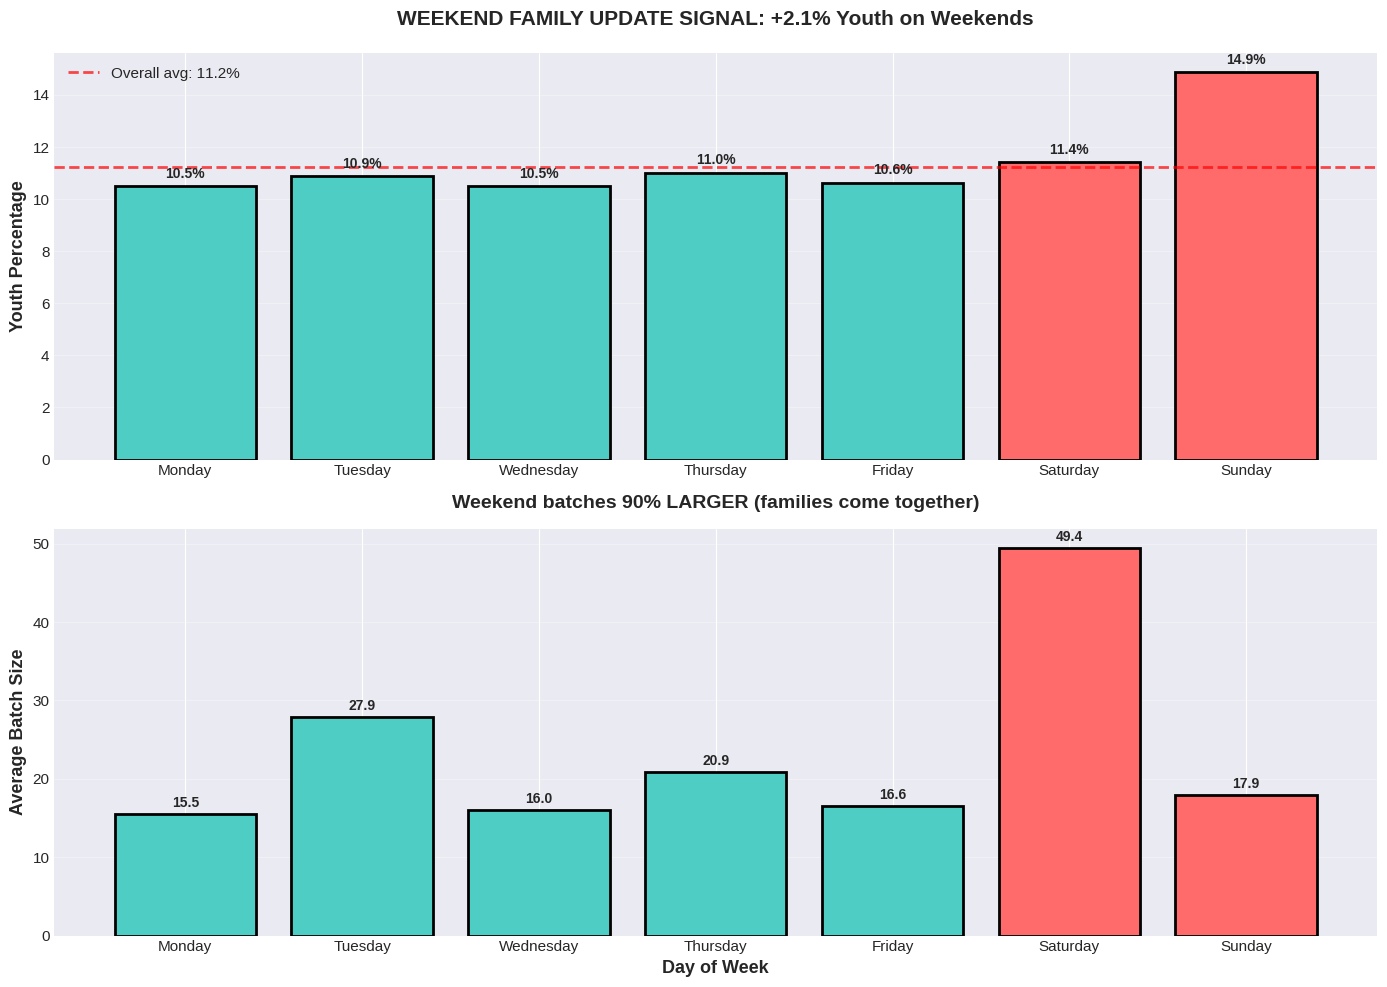


Creating Visualization 3: Geographic ALDI Distribution...
  ✓ Saved: demo_viz_3_aldi_geographic.png


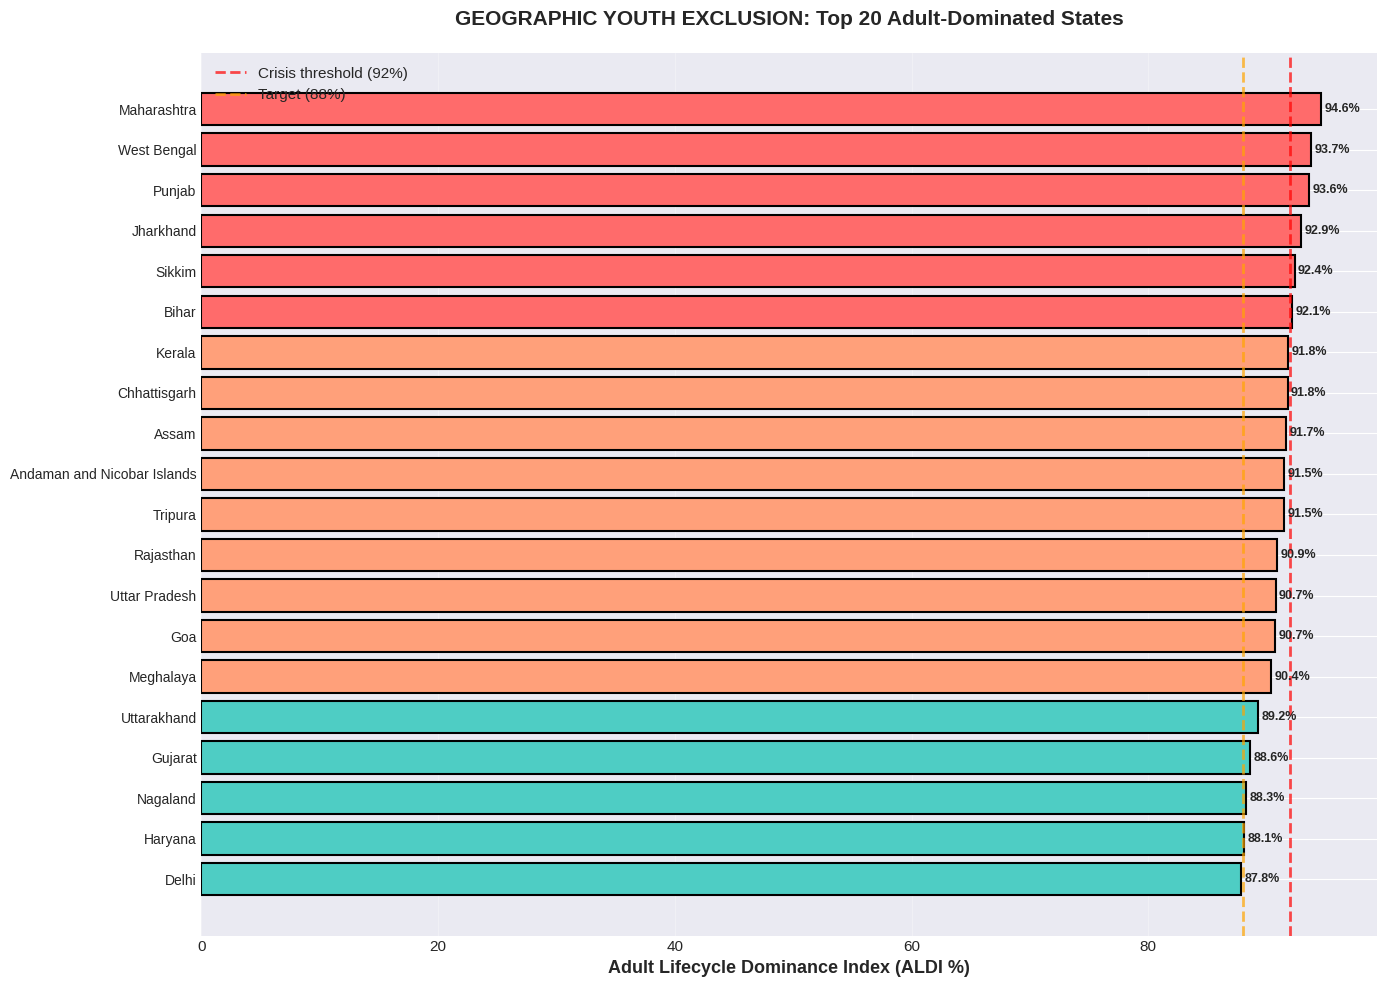


Creating Visualization 4: Institutional Youth Deficit...
  ✓ Saved: demo_viz_4_batch_youth_deficit.png


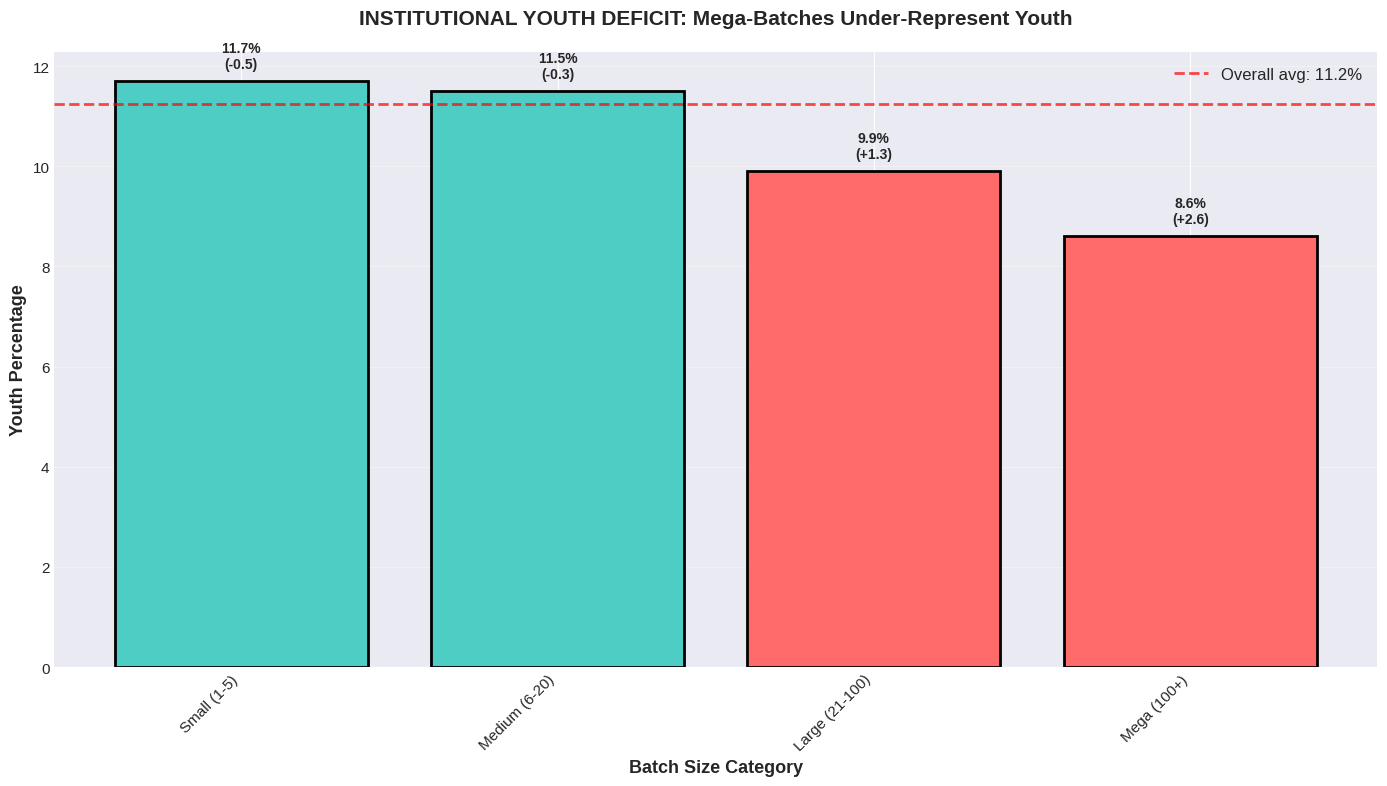


Creating Visualization 5: Pure Adult Batch Distribution...
  ✓ Saved: demo_viz_5_pure_adult_epidemic.png


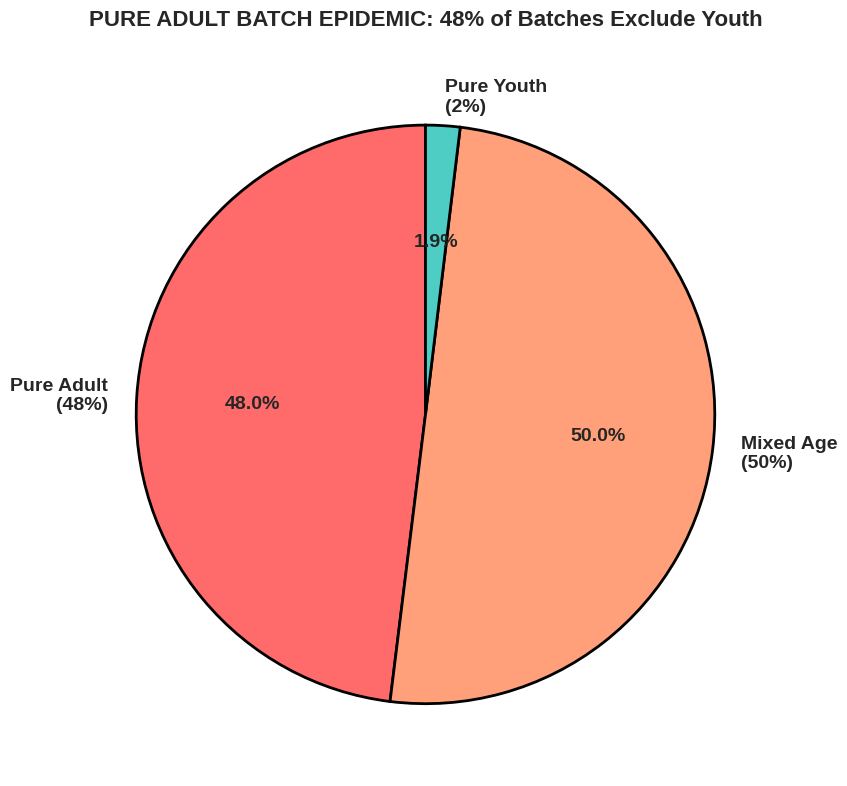


 ALL DEMOGRAPHIC VISUALIZATIONS CREATED!


In [ ]:
print("\n" + "="*80)
print("CREATING DEMOGRAPHIC VISUALIZATIONS")
print("="*80)

# VIZ 1: Adult Dominance Over Time
print("\nCreating Visualization 1: Adult Dominance Temporal Stability...")

monthly_age = df.groupby('year_month').agg({
    'pct_age_5_17': 'mean',
    'pct_age_17_above': 'mean'
}).round(1)

fig, ax = plt.subplots(figsize=(14, 8))

months = monthly_age.index
x = range(len(months))

ax.fill_between(x, 0, monthly_age['pct_age_5_17'],
               label='Youth (5-17)', alpha=0.7, color='#FF6B6B')
ax.fill_between(x, monthly_age['pct_age_5_17'], 100,
               label='Adult (17+)', alpha=0.7, color='#4ECDC4')

ax.axhline(11.2, color='red', linestyle='--', linewidth=2,
          label='Youth avg: 11.2%', alpha=0.7)

ax.set_xticks(x)
ax.set_xticklabels(months, rotation=45)
ax.set_xlabel('Month', fontsize=13, fontweight='bold')
ax.set_ylabel('Percentage', fontsize=13, fontweight='bold')
ax.set_title('ADULT DOMINANCE: 89% Adults vs 11% Youth (Stable Over Time)',
            fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12, loc='upper right')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('demo_viz_1_adult_dominance.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: demo_viz_1_adult_dominance.png")
plt.show()

# VIZ 2: Weekend Family Update Pattern
print("\nCreating Visualization 2: Weekend Family Update Pattern...")

dow_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
dow_youth = df.groupby('day_of_week')['pct_age_5_17'].mean().reindex(dow_order)
dow_batch = df.groupby('day_of_week')['total_demographic'].mean().reindex(dow_order)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Youth percentage
colors = ['#FF6B6B' if day in ['Saturday', 'Sunday'] else '#4ECDC4' for day in dow_order]
bars1 = ax1.bar(dow_order, dow_youth, color=colors, edgecolor='black', linewidth=2)
ax1.axhline(overall_youth_pct, color='red', linestyle='--', linewidth=2,
           label=f'Overall avg: {overall_youth_pct:.1f}%', alpha=0.7)
ax1.set_ylabel('Youth Percentage', fontsize=13, fontweight='bold')
ax1.set_title('WEEKEND FAMILY UPDATE SIGNAL: +2.1% Youth on Weekends',
             fontsize=15, fontweight='bold', pad=20)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3, axis='y')

for bar, pct in zip(bars1, dow_youth):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.2,
           f'{pct:.1f}%', ha='center', va='bottom', fontsize=10, fontweight='bold')

# Batch size
bars2 = ax2.bar(dow_order, dow_batch, color=colors, edgecolor='black', linewidth=2)
ax2.set_xlabel('Day of Week', fontsize=13, fontweight='bold')
ax2.set_ylabel('Average Batch Size', fontsize=13, fontweight='bold')
ax2.set_title('Weekend batches 90% LARGER (families come together)',
             fontsize=14, fontweight='bold', pad=15)
ax2.grid(True, alpha=0.3, axis='y')

for bar, size in zip(bars2, dow_batch):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
           f'{size:.1f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('demo_viz_2_weekend_pattern.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: demo_viz_2_weekend_pattern.png")
plt.show()

# VIZ 3: Geographic Youth Exclusion (ALDI Map)
print("\nCreating Visualization 3: Geographic ALDI Distribution...")

fig, ax = plt.subplots(figsize=(14, 10))

state_aldi_plot = state_aldi.sort_values(ascending=True).tail(20)
colors_aldi = ['#FF6B6B' if x > 92 else '#FFA07A' if x > 90 else '#4ECDC4'
               for x in state_aldi_plot]

bars = ax.barh(range(len(state_aldi_plot)), state_aldi_plot,
              color=colors_aldi, edgecolor='black', linewidth=1.5)

ax.set_yticks(range(len(state_aldi_plot)))
ax.set_yticklabels(state_aldi_plot.index, fontsize=10)
ax.set_xlabel('Adult Lifecycle Dominance Index (ALDI %)', fontsize=13, fontweight='bold')
ax.set_title('GEOGRAPHIC YOUTH EXCLUSION: Top 20 Adult-Dominated States',
            fontsize=15, fontweight='bold', pad=20)
ax.axvline(92, color='red', linestyle='--', linewidth=2,
          label='Crisis threshold (92%)', alpha=0.7)
ax.axvline(88, color='orange', linestyle='--', linewidth=2,
          label='Target (88%)', alpha=0.7)
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3, axis='x')

for bar, val in zip(bars, state_aldi_plot):
    width = bar.get_width()
    ax.text(width + 0.3, bar.get_y() + bar.get_height()/2.,
           f'{val:.1f}%', ha='left', va='center', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('demo_viz_3_aldi_geographic.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: demo_viz_3_aldi_geographic.png")
plt.show()

# VIZ 4: Batch Size vs Youth Deficit
print("\nCreating Visualization 4: Institutional Youth Deficit...")

fig, ax = plt.subplots(figsize=(14, 8))

batch_cats = age_by_batch.index
youth_pcts = age_by_batch['Avg_%_Youth']
colors_deficit = ['#FF6B6B' if y < overall_youth else '#4ECDC4' for y in youth_pcts]

bars = ax.bar(range(len(batch_cats)), youth_pcts, color=colors_deficit,
             edgecolor='black', linewidth=2)

ax.axhline(overall_youth, color='red', linestyle='--', linewidth=2,
          label=f'Overall avg: {overall_youth:.1f}%', alpha=0.7)

ax.set_xticks(range(len(batch_cats)))
ax.set_xticklabels(batch_cats, rotation=45, ha='right')
ax.set_xlabel('Batch Size Category', fontsize=13, fontweight='bold')
ax.set_ylabel('Youth Percentage', fontsize=13, fontweight='bold')
ax.set_title('INSTITUTIONAL YOUTH DEFICIT: Mega-Batches Under-Represent Youth',
            fontsize=15, fontweight='bold', pad=20)
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3, axis='y')

for bar, pct in zip(bars, youth_pcts):
    height = bar.get_height()
    deficit = overall_youth - pct
    label = f'{pct:.1f}%\n({deficit:+.1f})'
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.2,
           label, ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('demo_viz_4_batch_youth_deficit.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: demo_viz_4_batch_youth_deficit.png")
plt.show()

# VIZ 5: Pure Adult Batch Epidemic
print("\nCreating Visualization 5: Pure Adult Batch Distribution...")

age_comp_counts = pd.Series({
    'Pure Adult\n(48%)': df['is_pure_adult'].sum(),
    'Mixed Age\n(50%)': df['is_mixed_age'].sum(),
    'Pure Youth\n(2%)': df['is_pure_youth'].sum()
})

fig, ax = plt.subplots(figsize=(12, 8))

colors_comp = ['#FF6B6B', '#FFA07A', '#4ECDC4']
wedges, texts, autotexts = ax.pie(age_comp_counts, labels=age_comp_counts.index,
                                   autopct='%1.1f%%', startangle=90,
                                   colors=colors_comp, textprops={'fontsize': 14, 'fontweight': 'bold'},
                                   wedgeprops={'edgecolor': 'black', 'linewidth': 2})

ax.set_title('PURE ADULT BATCH EPIDEMIC: 48% of Batches Exclude Youth',
            fontsize=16, fontweight='bold', pad=20)

plt.tight_layout()
plt.savefig('demo_viz_5_pure_adult_epidemic.png', dpi=300, bbox_inches='tight')
print("  ✓ Saved: demo_viz_5_pure_adult_epidemic.png")
plt.show()

print("\n" + "="*80)
print(" ALL DEMOGRAPHIC VISUALIZATIONS CREATED!")
print("="*80)

### CELL 16: DOWNLOAD RESULTS

In [ ]:
print("\n" + "="*80)
print("DOWNLOAD FILES")
print("="*80)

from google.colab import files

# Download visualizations
print("\nDownloading visualizations...")
files.download('demo_viz_1_adult_dominance.png')
files.download('demo_viz_2_weekend_pattern.png')
files.download('demo_viz_3_aldi_geographic.png')
files.download('demo_viz_4_batch_youth_deficit.png')
files.download('demo_viz_5_pure_adult_epidemic.png')

# Save processed data
df.to_csv('demographic_processed_data.csv', index=False)
print("\nDownloading processed data...")
files.download('demographic_processed_data.csv')

# Save summary statistics
import json
demo_summary = {
    'overall_youth_pct': float(overall_youth_pct),
    'overall_adult_pct': float(overall_adult_pct),
    'pure_adult_pct': float(pure_adult_pct),
    'weekend_youth_surplus': float(weekend_surplus),
    'geographic_disparity': float(disparity),
    'mega_batch_deficit': float(youth_deficit),
    'high_aldi_states': int(high_aldi),
    'total_records': int(len(df)),
    'total_updates': int(df['total_demographic'].sum())
}

with open('demographic_statistics.json', 'w') as f:
    json.dump(demo_summary, f, indent=2)

print("\nDownloading statistics...")
files.download('demographic_statistics.json')

print("\n" + "="*80)
print(" DEMOGRAPHIC ANALYSIS COMPLETE!")
print("="*80)
print("\nYou now have:")
print("  ✓ 5 publication-quality visualizations (PNG, 300 DPI)")
print("  ✓ Processed dataset with derived features")
print("  ✓ Demographic statistics in JSON format")
print("  ✓ All 7 lifecycle insights ready for presentation")
print("\nKey Message:")
print("   94% adult dominance reveals youth invisibility")
print("   48% pure adult batches = structural exclusion")
print("   Weekend +2.1% youth = family access constraint")
print("   3.7x geographic disparity = migration-driven exclusion")



DOWNLOAD FILES



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


 DEMOGRAPHIC ANALYSIS COMPLETE!

You now have:
  ✓ 5 publication-quality visualizations (PNG, 300 DPI)
  ✓ Processed dataset with derived features
  ✓ Demographic statistics in JSON format
  ✓ All 7 lifecycle insights ready for presentation

Key Message:
   94% adult dominance reveals youth invisibility
   48% pure adult batches = structural exclusion
   Weekend +2.1% youth = family access constraint
   3.7x geographic disparity = migration-driven exclusion

Go win that hackathon! 
